# Teacher Forcing in RNNs

**Roberto Fierimonte** - 19/02/2018

---

In [0]:
import datetime
import functools
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline 

tfd = tf.contrib.distributions
tfb = tf.contrib.bayesflow

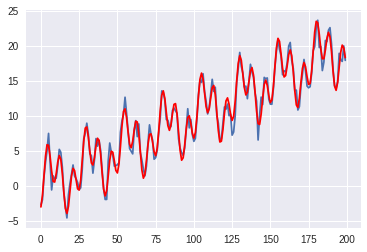

In [154]:
time = np.arange(0, 100, 0.5)
sigma = 1
y = 0.2 * time + 3 * np.sin(0.5 * time) - 3 * np.cos(1.5 * time)
y_tilde = y + sigma * np.random.randn(len(time))
plt.plot(y_tilde)
plt.plot(y, 'r')
ts = y_tilde

In [0]:
def doublewrap(function):
    """
    A decorator decorator, allowing to use the decorator to be used without
    parentheses if not arguments are provided. All arguments must be optional.
    """
    @functools.wraps(function)
    def decorator(*args, **kwargs):
        if len(args) == 1 and len(kwargs) == 0 and callable(args[0]):
            return function(args[0])
        else:
            return lambda wrapee: function(wrapee, *args, **kwargs)
    return decorator


@doublewrap
def define_scope(function, scope=None, *args, **kwargs):
    """
    A decorator for functions that define TensorFlow operations. The wrapped
    function will only be executed once. Subsequent calls to it will directly
    return the result so that operations are added to the graph only once.
    The operations added by the function live within a tf.variable_scope(). If
    this decorator is used with arguments, they will be forwarded to the
    variable scope. The scope name defaults to the name of the wrapped
    function.
    """
    attribute = '_cache_' + function.__name__
    name = scope or function.__name__
    @property
    @functools.wraps(function)
    def decorator(self):
        if not hasattr(self, attribute):
            with tf.variable_scope(name, *args, **kwargs):
                setattr(self, attribute, function(self))
        return getattr(self, attribute)
    return decorator

# Baseline Model

In [0]:
class LinearCell(tf.contrib.rnn.RNNCell):
    """
    """
    def __init__(self, output_size, state_size, reuse=None):
        super(LinearCell, self).__init__(_reuse=reuse)
        self._output_size = output_size
        self._state_size = state_size
    
    @property
    def state_size(self):
        return self._state_size
    
    @property
    def output_size(self):
        return self._output_size
    
    def call(self, inputs, state):
        state = tf.layers.dense(inputs, self._state_size) + tf.layers.dense(state, self._state_size)
        out = tf.layers.dense(state, self._output_size)
        return out, state

class SimpleSamplingCell(tf.contrib.rnn.RNNCell):
    """
    """
    def __init__(self, cell, output_size, layer, reuse=None):
        super(SimpleSamplingCell, self).__init__(_reuse=reuse)
        self._cell = cell
        self._output_size = output_size
        self._layer = layer

    @property
    def state_size(self):
        return (self._cell.state_size, self._output_size)

    @property
    def output_size(self):
        return (self._output_size)
    
    def call(self, inputs, state_and_sample):
        del inputs  # Unused.
        (state, sample) = state_and_sample
        out, state = self._cell(sample, state)
        sample = self._layer(out)
        return sample, (state, sample)
    
class BaselineModel(object):
    """
    """
    def __init__(self, cell_type='GRU', n_hidden=100):
        self._n_hidden = n_hidden
        self._cell_type = cell_type
        if cell_type == 'Linear':
            self._cell = LinearCell(1, self._n_hidden)
            self._sampling_cell = self._cell
        else:
            self._layer = tf.layers.Dense(1)
            if cell_type == 'GRU':
                self._cell = tf.contrib.rnn.GRUBlockCell(self._n_hidden)
            elif cell_type == 'LSTM':
                self._cell = tf.contrib.rnn.LSTMBlockCell(self._n_hidden)
            elif cell_type == 'RNN':
                self._cell = tf.contrib.rnn.BasicRNNCell(self._n_hidden)
            self._sampling_cell = SimpleSamplingCell(self._cell, 1, self._layer)

    def compute_forward(self, data):
        (out, hidden) = tf.nn.dynamic_rnn(self._cell, inputs=data, dtype=tf.float32)
        if self._cell_type != 'Linear':
            out = self._layer(out)
        return out, hidden    
    
    def pred_forward(self, data, last_training_point, last_hidden):
        inputs = tf.concat([last_training_point[:, None], data], 1)        
        (out, _) = tf.nn.dynamic_rnn(self._cell, inputs=inputs, initial_state=last_hidden, dtype=tf.float32)
        if self._cell_type != 'Linear':
            out = self._layer(out)
        return out
    
    def pred_forward_autoregressive(self, last_training_point, last_hidden, future=500):
        sample = last_training_point
        hidden = last_hidden
        samples = []
        
        for _ in range(future):
            (sample, hidden) = self._cell(sample, hidden)
            if self._cell_type != 'Linear':
                sample = self._layer(sample)
            samples.append(sample)
            
        return tf.transpose(tf.stack(samples, 0), [1,0,2])

In [157]:
tf.reset_default_graph()

seq_length = 150; cell_type = 'Linear'; n_hidden = 10
x_ = tf.placeholder(tf.float32, [None, None, 1])
x_test = tf.placeholder(tf.float32, [None, None, 1])

with tf.variable_scope(cell_type + '_' + str(n_hidden), reuse=tf.AUTO_REUSE) as scope:
    model = BaselineModel(cell_type, n_hidden)
    res, hidden = model.compute_forward(x_[:, :-1])
    loss = tf.reduce_mean(tf.reduce_sum(tf.square(res[..., 0] - x_[:, 1:, 0]), 1))/2
    optimise = tf.train.AdamOptimizer(0.001).minimize(loss)
    
    pred_tf = model.pred_forward(x_test, x_[:, -1], hidden)
    pred_ar_tf = model.pred_forward_autoregressive(x_[:, -1], hidden, future=100)

config = tf.ConfigProto(allow_soft_placement=True)
sess = tf.InteractiveSession(config=config) 
sess.run(tf.global_variables_initializer())

saver = tf.train.Saver()
errors_baseline = []; preds_baseline = []; preds_baseline_ar = []; errors_test_baseline = []

timestamp = datetime.datetime.strftime(datetime.datetime.now(), "%Y-%m-%d_%H:%M")

for i in range(10001):
    batch = ts[None, :seq_length+1]
#     batch = np.stack([ts[i:i+seq_length] for i in np.random.randint(0, 150-seq_length, 10)])    
    error = sess.run(loss, {x_: batch[..., None]})
    sess.run(optimise, {x_: batch[..., None]})
    errors_baseline.append(error)
    
    if i % 1000 == 0:
        test_batch = ts[seq_length+1:]
        test_error = sess.run(loss, {x_: test_batch[None, :, None]})
        errors_test_baseline.append(test_error)
        print('Iteration:', i, 'Training Error:', error, 'Test Error:', test_error)
        pred = sess.run(pred_tf, {x_: ts[None, :seq_length+1, None], x_test: ts[None, seq_length+1:, None]})
        pred_ar = sess.run(pred_ar_tf, {x_: ts[None, :seq_length, None]})
        preds_baseline.append(pred); preds_baseline_ar.append(pred_ar)
        
# save_path = saver.save(sess, "/mnt/workspace/baseline_{}_length_{}_iter_{}.ckpt".format(timestamp, seq_length, i))

Iteration: 0 Training Error: 532596.6 Test Error: 387938.47
Iteration: 1000 Training Error: 794.7384 Test Error: 623.28
Iteration: 2000 Training Error: 217.19664 Test Error: 535.2322
Iteration: 3000 Training Error: 175.2297 Test Error: 566.4844
Iteration: 4000 Training Error: 171.34695 Test Error: 193.30357
Iteration: 5000 Training Error: 152.93503 Test Error: 188.87491
Iteration: 6000 Training Error: 137.89296 Test Error: 203.2348
Iteration: 7000 Training Error: 123.22671 Test Error: 240.41193
Iteration: 8000 Training Error: 97.29881 Test Error: 692.8097
Iteration: 9000 Training Error: 92.56614 Test Error: 1045.4834
Iteration: 10000 Training Error: 92.92415 Test Error: 1252.7979


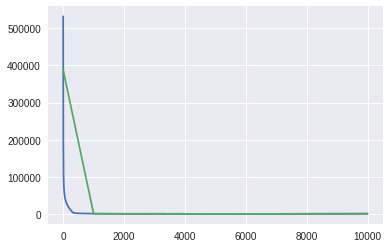

In [161]:
plt.plot(errors_baseline)
plt.plot(range(0, 10001, 1000), errors_test_baseline)

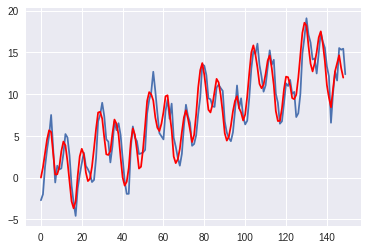

In [162]:
fit = sess.run(res, {x_: ts[None, :150, None]})
plt.plot(ts[None, :150].T)
plt.plot(fit[..., 0].T, 'r')

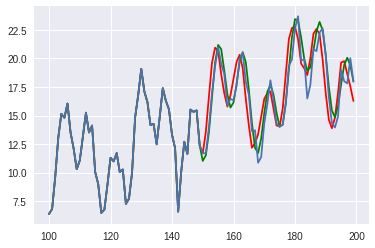

In [163]:
plt.plot(range(100, 200), np.concatenate([ts[None, 100:150, None], pred], 1)[0], 'r')
plt.plot(range(100, 200), np.concatenate([ts[None, 100:150, None], pred_ar[:, :50]], 1)[0], 'g-')
plt.plot(range(100, 200), ts[None, 100:200].T)

# Our Model

In [0]:
class RecognitionNetwork(object):
    
    def __init__(self, n_outputs=50, cell_type='GRU', n_hidden=100):
        self._n_outputs = n_outputs
        self._n_hidden = n_hidden
        self._layer1 = tf.layers.Dense(self._n_outputs)
        self._layer2 = tf.layers.Dense(self._n_outputs, tf.nn.softplus)
        
        if cell_type == 'GRU':
            self._cell = tf.contrib.rnn.GRUBlockCell(self._n_hidden)
        elif cell_type == 'LSTM':
            self._cell = tf.contrib.rnn.LSTMBlockCell(self._n_hidden)
        elif cell_type == 'RNN':
            self._cell = tf.contrib.rnn.BasicRNNCell(self._n_hidden)
            
    def __call__(self, data):        
        (out, _) = tf.nn.dynamic_rnn(self._cell, data, dtype=tf.float32)
        means = self._layer1(out[:, -1])
        stds = self._layer2(out[:, -1])
        return tfd.MultivariateNormalDiag(means, stds)

class LinearGaussianCell(tf.contrib.rnn.RNNCell):
    """
    RNN cell that outputs mean and standard deviation at every step as a function
    of the hidden state.
    """
    def __init__(self, event_size, state_size, reuse=None):
        super(LinearGaussianCell, self).__init__(_reuse=reuse)
        self._state_size = state_size
        self._event_size = event_size

    @property
    def state_size(self):
        return self._state_size

    @property
    def output_size(self):
        return (self._event_size, self._event_size)

    def call(self, inputs, state):
        state = tf.layers.dense(inputs, self._state_size) + tf.layers.dense(state, self._state_size)
        mean = tf.layers.dense(state, self._event_size)
        std = tf.layers.dense(state, self._event_size, tf.nn.softplus)
        
        return (mean, std), state
    
class GaussianCell(tf.contrib.rnn.RNNCell):
    """
    RNN cell that outputs mean and standard deviation at every step as a function
    of the hidden state.
    """
    def __init__(self, cell, event_size, reuse=None):
        super(GaussianCell, self).__init__(_reuse=reuse)
        self._cell = cell
        self._event_size = event_size

    @property
    def state_size(self):
        return self._cell.state_size

    @property
    def output_size(self):
        return (self._event_size, self._event_size)

    def call(self, inputs, state):
        _, state = self._cell(inputs, state)
        mean = tf.layers.dense(state, self._event_size)
        std = tf.layers.dense(state, self._event_size, tf.nn.softplus)
        return (mean, std), state
    
class SamplingCell(tf.contrib.rnn.RNNCell):
    """
    RNN cell that produce a sequence in autoregressive mode by sampling at 
    each step. Currently unused.
    """
    def __init__(self, cell, output_size, reuse=None):
        super(SamplingCell, self).__init__(_reuse=reuse)
        self._cell = cell
        self._output_size = output_size

    @property
    def state_size(self):
        return (self._cell.state_size, self._output_size)

    @property
    def output_size(self):
        return (self._output_size, self._output_size)
    
    def call(self, inputs, state_and_sample):
        del inputs  # Unused.
        (state, sample) = state_and_sample
        (mean, std), state = self._cell(sample, state)
        sample = tfd.Normal(mean, std).sample()
        return (mean, std), (state, sample)
        
class RobustARGenerator(object):
    """
    Model to test
    """
    def __init__(self, data, n_hidden=100, n_samples=200, seq_length=1000):
        self._data = data
        self._n_hidden = n_hidden
        self._n_samples = n_samples
        self._seq_length = seq_length
        self._cell = LinearGaussianCell(1, self._n_hidden)
        self._initial_state = tf.zeros((self._n_samples, self._n_hidden))
        
        self._optimiser = tf.train.AdamOptimizer(0.001)
        
        self._gen_stddev = tf.nn.softplus(tf.get_variable('generative_std', shape=(), 
                                                          initializer=tf.constant_initializer(10)))
        self.make_posterior
        self.compute_elbo
        self.E_step
        self.M_step
    
    @define_scope
    def make_posterior(self):
        self._post_stddev = tf.nn.softplus(tf.get_variable('posterior_std', shape=(), 
                                                           initializer=tf.constant_initializer(10)))
        return tfd.MultivariateNormalDiag(self._data, scale_identity_multiplier=self._post_stddev)
    
    @define_scope
    def make_transitional(self):
        inputs = tf.concat([tf.zeros((self._n_samples, 1, 1)), self._code[:, 0, :-1]], 1)
        state = self._initial_state
#         (means, stds), _ = tf.nn.dynamic_rnn(self._cell, inputs=inputs,
#                                              initial_state=self._initial_state,
#                                              dtype=tf.float32)
        means = []; stds = []
        for t in range(self._seq_length):
            state = tf.layers.dense(state, self._n_hidden) + tf.layers.dense(inputs[:, t], self._n_hidden)
            mean = tf.layers.dense(state, 1); std = tf.layers.dense(state, 1, tf.nn.softplus)
            means.append(mean); stds.append(std)
            
        return tf.transpose(tf.stack(means, 0), [1,2,0]), tf.transpose(tf.stack(stds, 0), [1,2,0])
    
    @define_scope
    def compute_elbo(self):
        posterior = self.make_posterior
        self._code = posterior.sample((self._n_samples))
        
        entropy = self._seq_length * tf.log(self._post_stddev * tf.sqrt(2*np.pi*np.e))
        
        # Reconstruction Term        
        exponent_gen = tf.square(self._code[..., 0] - self._data[..., 0])/(2 * tf.square(self._gen_stddev))
        norm_constant_gen = tf.sqrt(2 * np.pi * tf.square(self._gen_stddev))
        reconstruction = tf.reduce_mean(tf.reduce_sum(-exponent_gen - tf.log(norm_constant_gen), -1))
        
        # "Prior"/Transitional Term
        means, stddevs = self.make_transitional
        means = means[..., 0]; stddevs = stddevs[..., 0]
        exponent_trans = tf.square(self._code[..., 0] - means)/(2 * tf.square(stddevs))
        norm_constant_trans = tf.sqrt(2 * np.pi * tf.square(stddevs))
        log_prob_trans = - tf.log(norm_constant_trans) - exponent_trans
        
        # KL Term
        kl = - entropy - tf.reduce_mean(tf.reduce_sum(log_prob_trans, 1)) 
        
        return reconstruction - kl, kl, reconstruction, entropy
    
    @define_scope
    def E_step(self):
        post_var = [v for v in tf.trainable_variables() if v.name.startswith('make_posterior/')]
        return self._optimiser.minimize(-self.compute_elbo[0], var_list=post_var)
    
    @define_scope
    def M_step(self):
        non_post_var = [v for v in tf.trainable_variables() if not v.name.startswith('make_posterior/')]
        return self._optimiser.minimize(-self.compute_elbo[0], var_list=non_post_var)

In [0]:
tf.reset_default_graph()

seq_length = 150;
x_ = tf.placeholder(tf.float32, [None, None, 1])

gen_model = RobustARGenerator(x_, n_hidden=20, n_samples=200, seq_length=seq_length)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()

elbos = []; kls = []; llks = []; test_elbos = []; preds = []; preds_greedy = []
means = []; stds = []; gen_stddevs = []; post_stddevs = []

for i in range(20001):
    batch = ts[:seq_length][None, ...]
    elbo, kl, llk, entropy = sess.run(gen_model.compute_elbo, {x_: batch[..., None]})
    elbos.append(elbo); kls.append(kl); llks.append(llk)
    
    if i % 1000 == 0:
        test_batch = ts[150:200]
#         test_elbo = sess.run(gen_model.compute_elbo[0], {x_: test_batch[None, :, None]})
#         test_elbos.append(test_elbos)
        latents = sess.run(gen_model._code, {x_: batch[..., None]})
        (m, s) = sess.run(gen_model.make_transitional, {x_: batch[..., None]})
        means.append(m); stds.append(s); gen_stddevs.append(sess.run(gen_model._gen_stddev))
        post_stddevs.append(sess.run(gen_model._post_stddev))
        print('Iteration:', i, 'ELBO:', elbo, 'KL:', kl, 'Reconstruction:', llk, 'Entropy:', entropy) #, 'Test ELBO:', test_elbo)
        
    sess.run(gen_model.E_step, {x_: batch[..., None]})
    sess.run(gen_model.M_step, {x_: batch[..., None]})

Iteration: 0 ELBO: -37801.637 KL: 37243.637 Reconstruction: -558.0019 Entropy: 558.22925
Iteration: 1000 ELBO: -907.2016 KL: 352.59937 Reconstruction: -554.60223 Entropy: 554.3467
Iteration: 2000 ELBO: -788.5521 KL: 236.58588 Reconstruction: -551.96625 Entropy: 552.38336
Iteration: 3000 ELBO: -764.177 KL: 213.71716 Reconstruction: -550.45984 Entropy: 550.2125
Iteration: 4000 ELBO: -758.7209 KL: 210.59375 Reconstruction: -548.12714 Entropy: 547.411
Iteration: 5000 ELBO: -751.16925 KL: 207.9107 Reconstruction: -543.25854 Entropy: 543.42035
Iteration: 6000 ELBO: -748.07043 KL: 210.24896 Reconstruction: -537.8215 Entropy: 537.3142


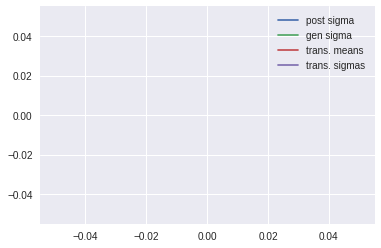

In [119]:
plt.plot(post_stddevs, label='post sigma')
plt.plot(gen_stddevs, label='gen sigma')
plt.plot([np.linalg.norm(m) for m in means], label='trans. means')
plt.plot([np.linalg.norm(s) for s in stds], label='trans. sigmas')
plt.legend()

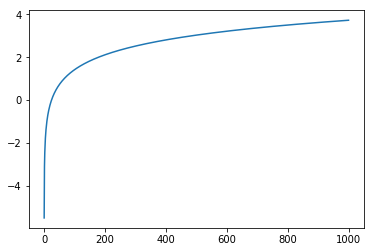

In [0]:
plt.plot([np.log(sigma * np.sqrt(2*np.pi*np.e)) for sigma in np.arange(0.001, 10, 0.01)])

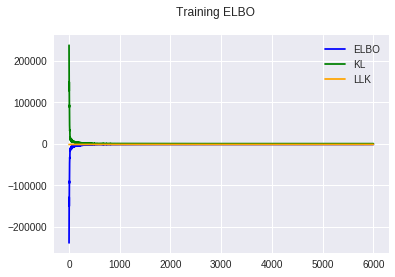

In [0]:
plt.plot(elbos, 'b', label='ELBO')
plt.plot(kls, 'g', label='KL')
plt.plot(llks, 'orange', label='LLK')
plt.suptitle('Training ELBO')
plt.legend()
plt.show()

In [0]:
sess.run(gen_model._gen_stddev)

8.45173

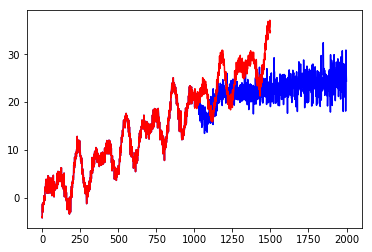

In [0]:
pred = sess.run(model.predict_forward, {x_: ts[:seq_length, None].T})
for i in range(1):
    plt.plot(np.concatenate([ts[:seq_length], pred[i]]), 'b')
plt.plot(np.concatenate([ts[:seq_length], ts[seq_length:seq_length+500]]), 'r')

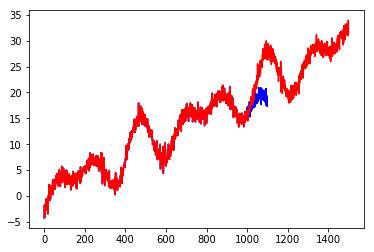

In [0]:
pred = sess.run(model.predict_forward, {x_: ts[:seq_length, None].T})
for i in range(1):
    plt.plot(np.concatenate([ts[:seq_length], pred[i][:500]]), 'b')
plt.plot(np.concatenate([ts[:seq_length], ts[seq_length:seq_length+500]]), 'r')

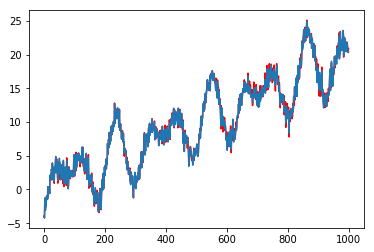

In [0]:
m, s = sess.run(model.make_transitional, {x_: ts[:seq_length, None].T})
plt.plot(ts[:seq_length], 'r')
plt.plot(m[0, :, 0])

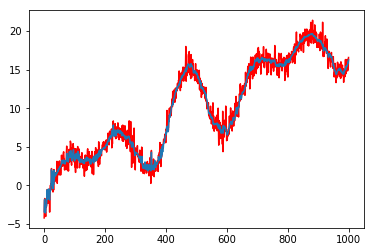

In [0]:
m, s = sess.run(model.make_transitional, {x_: ts[:seq_length, None].T})
plt.plot(ts[:seq_length], 'r')
plt.plot(m[0, :, 0])

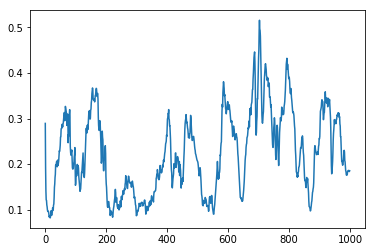

In [0]:
plt.plot(s[0, :, 0])

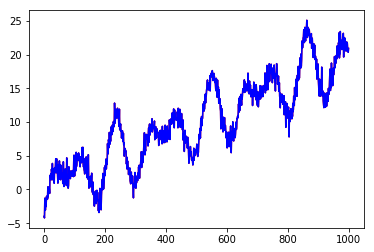

In [0]:
plt.plot(ts[:seq_length], 'r', test_latents[0, :, 0], 'b')

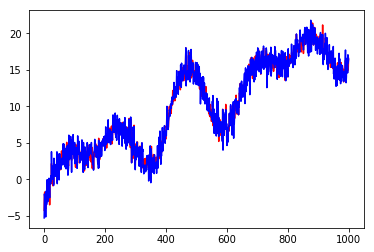

In [0]:
plt.plot(ts[:seq_length], 'r', test_latents[0, :, 0], 'b')